### Integrantes del grupo
* Carlos Madrid Urbano
* Alejandro Pérez Sanjuán

In [3]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from sklearn.datasets import load_sample_images
from skimage.metrics import peak_signal_noise_ratio
from skimage.data import astronaut, coffee, cat, rocket, binary_blobs, brain, clock
from utils import (
    add_noise,
    get_sketch,
    mean_filter,
    median_filter,
    add_salt_pepper,
    adaptive_median_filter,
    fourier_transform_denoising,
)

from utils import (
    thresholding,
    dilate,
    erosion,
    opening,
    closing
)

In [2]:
# ignore Numba warnings
warnings.filterwarnings('ignore')

In [3]:
dataset = load_sample_images()
building, flower = dataset['images'][0], dataset['images'][1]
images = [astronaut(), coffee(), cat(), rocket(), building, flower]

## Introducción
En este documento se presenta una breve review de diferentes filtros espaciales utilizados en procesamiento de imagen.

Algunos se han implementado desde cero, e incluyen un property de jit compiling para que funcionen de forma óptima. Otros se han tomado de la librería Skimage.

En el último apartado se presenta una combinación de técnicas para `sketchizar` una imagen.


## Filtros espaciales
De acuerdo con la literatura revisada (referencias al final del documento), a la hora de suprimir ruido en imágenes, los filtros espaciales se presentan como una opción sencilla y sin un sobrecoste en cuanto a procesamiento. Sin embargo, la utilización de estos filtros conlleva una contrapartida, en su mayoría reducen notablemente los detalles en la imagen.

En general, estos filtros son eficaces frente a dos tipos de ruidos:
* Sal y pimienta
* Ruido gausiano

Para el ruido `sal y pimienta` se suelen considerar filtros espaciales como los descritos a continuación:
* **Filtro de media.** El píxel considerado se sustituye por la media de sus vecinos. La operación se aplica en ventana deslizante. Elimina una cantidad considerable de detalles.

* **Filtro de mediana.** El píxel considerado se sustituye por la mediana de sus vecinos. La operación se aplica en ventana deslizante. Es más efectivo frente al rudio sal y pimienta.

* **Gaussian smoothing.** Aplica una operación de convolución con un kernel gausiano para eliminar ruido. Como contrapartida, el Kernel también elimina detalles.


Los tres presentan un comportamiento similar, son robustos frente al ruido moderado pero su utilización conlleva la pérdida de detalles en la imagen.

Para mejorar el comportamiento de estos filtros se va a introducir un filtro de mediana mejorado basado en la propuesta de *Amulya Bhanu, Nepalati & Sivaram*. Dicha propuesta consiste en la creación de un filtro de mediana adaptativo donde se evalúa la cualidad de ruido de cada píxel considerado de tal forma que, dado un criterio, un píxel se sustituirá por la mediana de sus vecinos si es considerado ruido y se dejará sin reemplazar cuando no.

En este documento se ha optado por que un píxel se puede considerar ruido cuando su valor está por encima o debajo de la media del valor de los píxeles vecinos más/menos su desviación estándar en un area de tamaño $N$ píxeles. El tamaño de este área puede o no coincidir con el kernel que se use para realizar el filtro.

Adicionalmente, en la literatura también se consideran los denominados **filtros de frecuencia**, como la transformada de Fourier. En el caso particular de Fourier, la operación se puede considerar también un filtro espacial teniendo en cuenta el [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem).

Se ha dejado comentada una versión de filtrado basada en la transformada de Fourier discreta porque se considera que queda algo fuera del scope de este trabajo y porque los resultados con la configuración actual no son muy prometedores. Para ejecutarla se debe cambiar el valor de `ncols=5` a `ncols=6` y descomentar las líneas apropiadas. Funciona filtrando las frecuencias en cada canal de la imagen, que previamente se ha desplegado sobre una única dimensión.

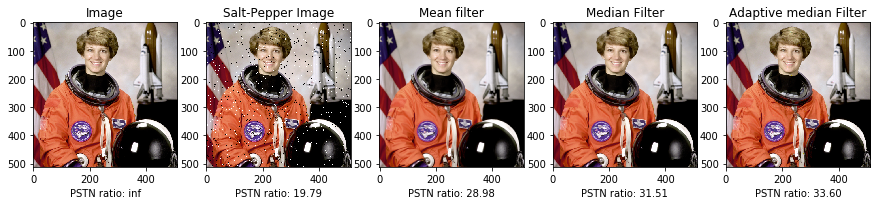

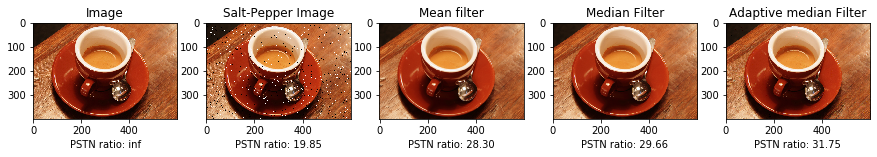

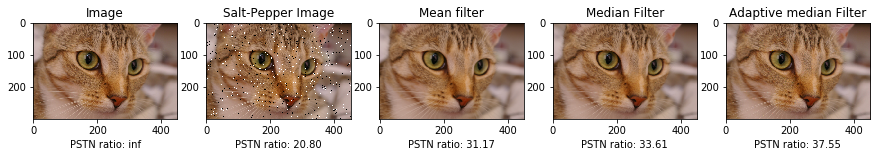

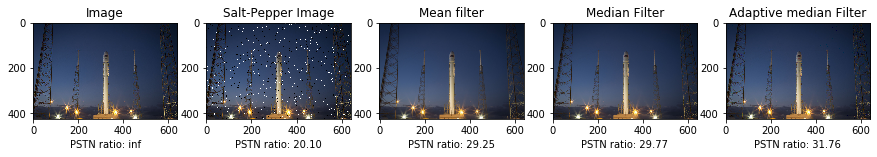

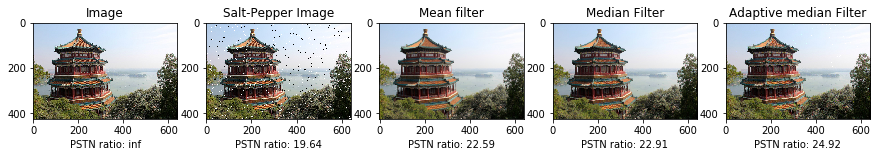

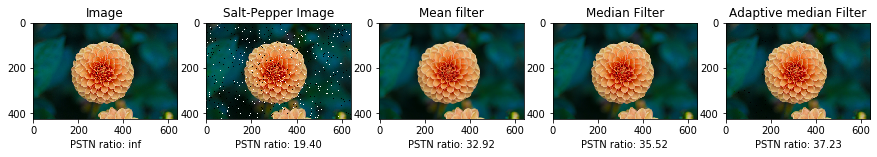

In [4]:
for img in images:
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,10))
    
    noisy = add_salt_pepper(image=img, prob=0.03)
    
    ax[0].imshow(img)
    ax[0].set_title('Image')
    ax[0].set_xlabel(f'PSTN ratio: inf')
    
    ax[1].imshow(noisy)
    ax[1].set_title('Salt-Pepper Image')
    ax[1].set_xlabel(f"PSTN ratio: {peak_signal_noise_ratio(image_true=img, image_test=noisy):0.2f}")
    
    mean = mean_filter(img)
    ax[2].imshow(mean)
    ax[2].set_title('Mean filter')
    ax[2].set_xlabel(f"PSTN ratio: {peak_signal_noise_ratio(image_true=img, image_test=mean):0.2f}")
    
    median = median_filter(noisy)
    ax[3].imshow(median)
    ax[3].set_title('Median Filter')
    ax[3].set_xlabel(f"PSTN ratio: {peak_signal_noise_ratio(image_true=img, image_test=median):0.2f}")
    
    ad_median = adaptive_median_filter(noisy)
    ax[4].imshow(ad_median)
    ax[4].set_title('Adaptive median Filter')
    ax[4].set_xlabel(f"PSTN ratio: {peak_signal_noise_ratio(image_true=img, image_test=ad_median):0.2f}")
    
    """
    fft = fourier_transform_denoising(noisy, n_components=1000)
    ax[5].imshow(fft)
    ax[5].set_title('Fourier Transform')
    ax[5].set_xlabel(f"PSTN ratio: {peak_signal_noise_ratio(image_true=img, image_test=fft):0.2f}")
    """
    
    plt.show()

Tanto el filtro de media como el filtro de mediana eliminan la anomalía de sal y pimienta. El filtro de mediana es ligeramente superior por ser la media un estimador no robusto. Como contrapartida, la nitidez de la imagen se ver reducida; sin embargo, el filtro de mediana adaptativo reduce ligeramente la pérdida de información. La mejora es claramente superior ante imágenes con gran cantidad de detalles.

## Operaciones morfológicas

Por lo general, la literatura menciona las siguientes operaciones morfológicas:

* **Dilatación** Cada píxel $(i,j)$ se sustituye por el máximo de los píxeles vecinos centrados en $(i,j)$
* **Erosión** Cada píxel $(i,j)$ se sustituye por el mínimo de los píxeles vecinos centrados en $(i,j)$
* **Apertura** operación de erosión seguida de operación de dilatación.
* **Cierre** operación de dilatación seguida de operación de erosión.

In [5]:
import skimage
from skimage import data, filters


images = [data.page(), data.coins(), data.camera(), data.brick(), data.grass()]

Tomaremos imágenes en blanco y negro para simplificar el proceso. En caso de ser RGB, se aplicaría sobre cada canal.

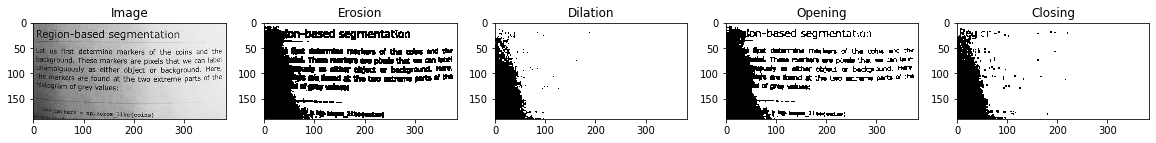

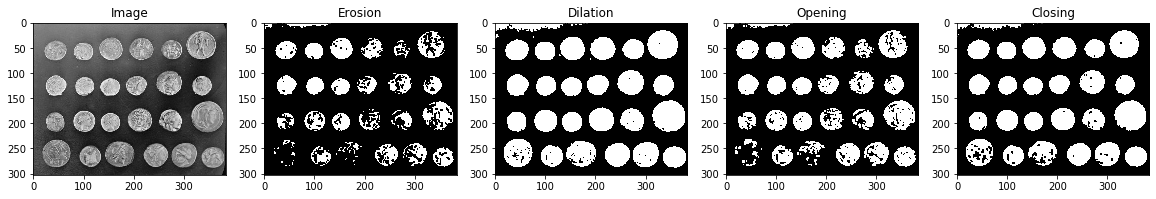

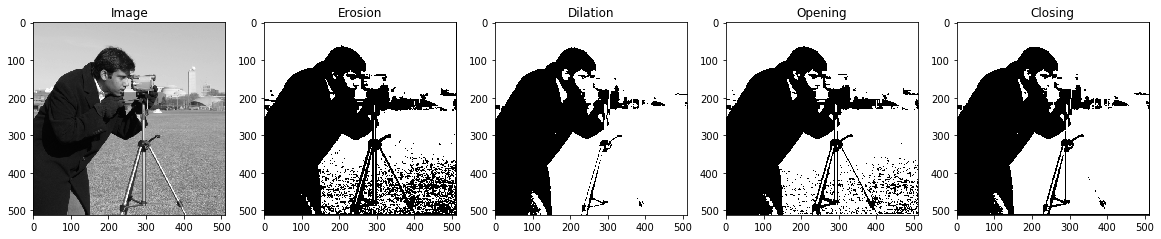

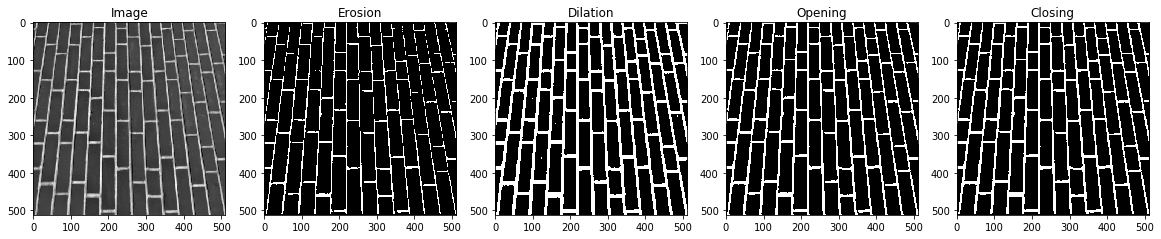

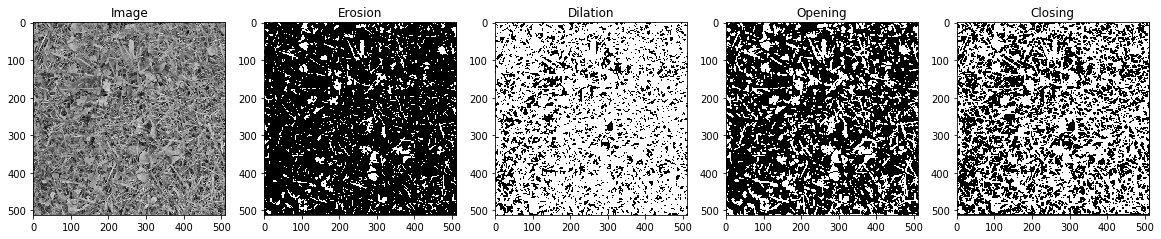

In [6]:
for img in images:
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,25))
    
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Image')
    
    _erosion = erosion(thresholding(img, 127))
    ax[1].imshow(_erosion, cmap='gray')
    ax[1].set_title('Erosion')
    
    
    _dilation = dilate(thresholding(img, 127))
    ax[2].imshow(_dilation, cmap='gray')
    ax[2].set_title('Dilation')
    
    _opening = opening(thresholding(img, 127))
    ax[3].imshow(_opening, cmap='gray')
    ax[3].set_title('Opening')
    
    _closing = closing(thresholding(img, 127))
    ax[4].imshow(_closing, cmap='gray')
    ax[4].set_title('Closing')

    plt.show()

## Propuesta de filtro: sketching effect
A continuación, se propone una combinación de técnicas para aplicar un estilo *sketch* a una imagen dada. 

En primer lugar se aplica un filtro gaussiano para emborronar la imagen. El filtro funciona mediante una operación de convolución.

Para detectar los bordes se utiliza el algoritmo de `Canny`, que generalmente consta de 5 pasos:
* **Reducción de ruido:** normalmente se usa un filtro gaussiano para suavizar la imagen.

* **Cálculo de gradiente:** detecta la intensidad y dirección de los bordes.

* **Supresión:** se reduce el grosor de los bordes.

* **Umbralización:** mediante un doble umbral, se identifican píxels fuertes (alta intensidad) y píxeles débiles (baja intensidad). Existe un tercer conjunto de píxels que se considera no relevante para los bordes.

* **Tratamiento de bordes:** los píxeles débiles se transforman en píxels fuertes mediante un proceso llamado histéresis.

Finalmente, la función `get_sketch` multiplica los bordes por la imagen filtrada (gaussian filter) y realiza una operación clip para mantener los valores en el intervalo $[0,1]$ (o $[0, 255]$)

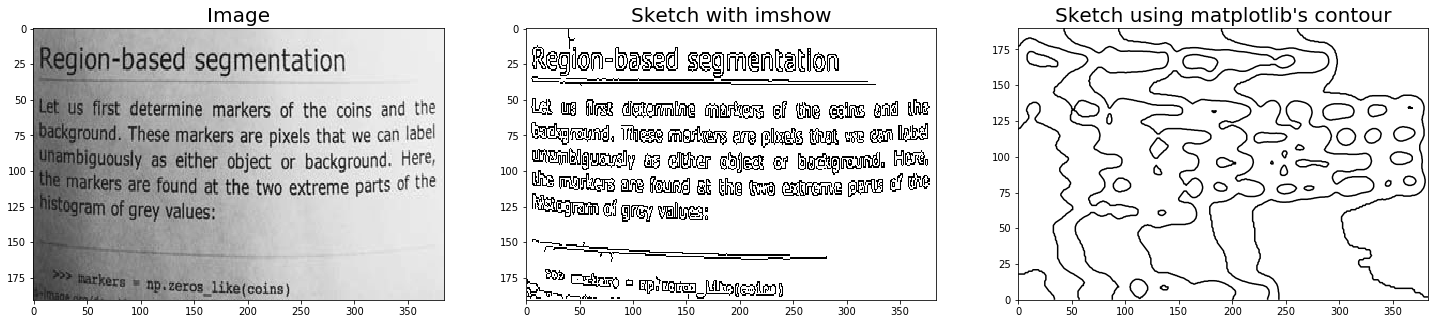

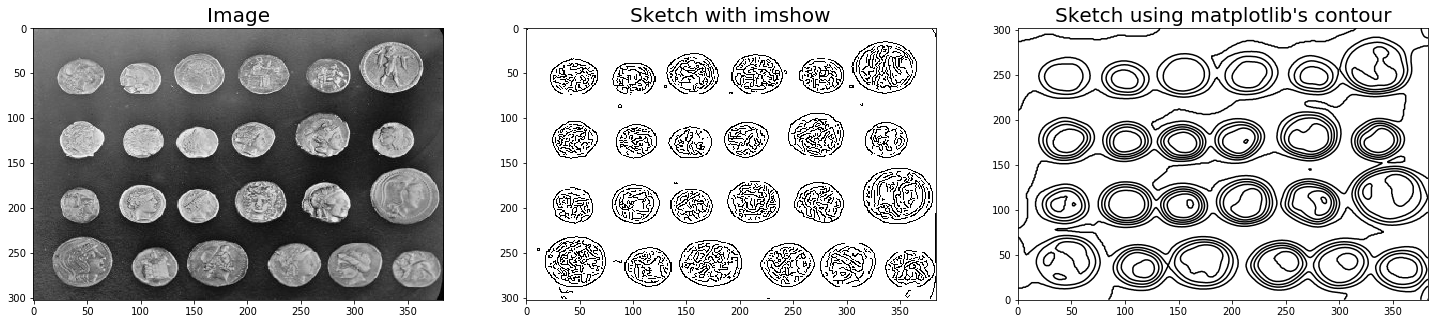

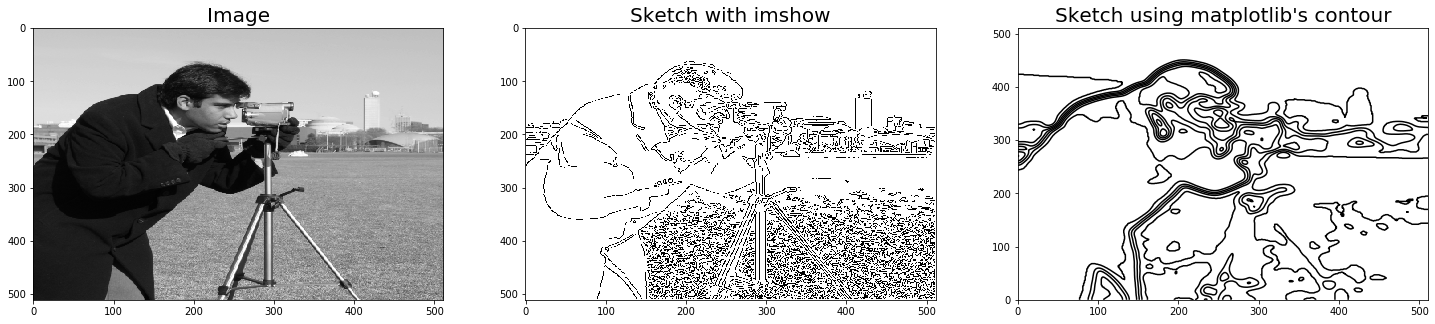

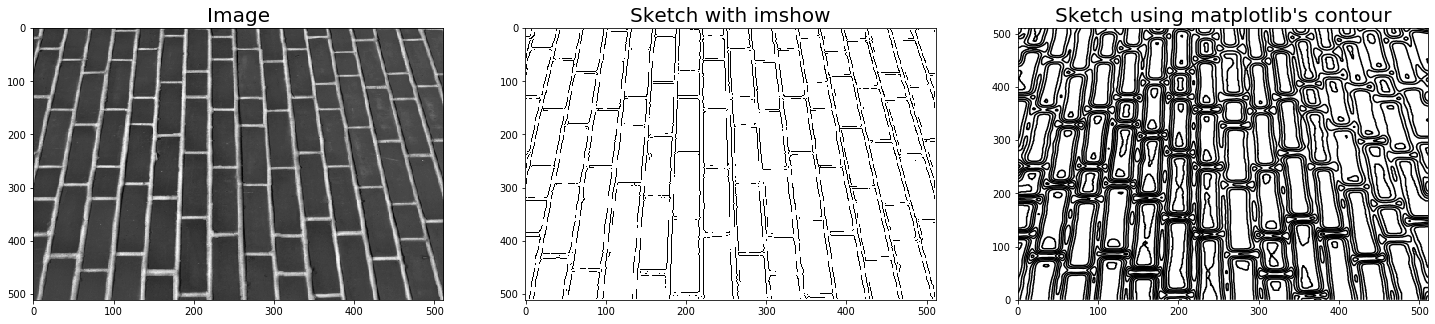

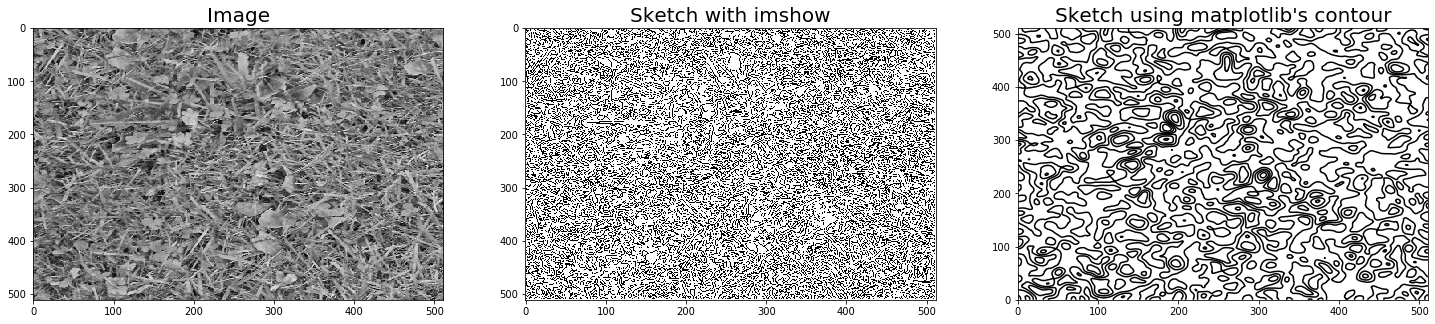

In [7]:
for img in images:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    
    # blurr, edge detection, sketchify
    blurred = ndimage.gaussian_filter(img, 5)
    canny = skimage.feature.canny(img, 0.8)
    sketch = get_sketch(img=blurred, contour=canny)
    
    ax[0].imshow(img, cmap='gray', aspect="auto")
    ax[0].set_title('Image', fontsize=20)
    
    ax[1].imshow(1 - sketch, cmap='gray', aspect="auto")
    ax[1].set_title('Sketch with imshow', fontsize=20)
    
    ax[2].contour(np.flipud(blurred), colors='k')
    ax[2].set_title("Sketch using matplotlib's contour", fontsize=20)

Como extra, se ha añadido una columna de imágenes que hacen uso de la función `countour` de matplotlib. La función permite representar valores $(x,y)$ teniendo en cuenta $z$ como nivel de "countour".

En este caso, se ha utilizado directamente la imagen emborronada con el filtro gausiano. El resultado es muy llamativo por su nitidez y por generar un dibujo de estilo abstracto.

## Conclusión
En este documente se han visto tanto filtros espaciales como operaciones morfológicas aplicas al procesamiento de imágenes.

Se ha observado que algoritmos simples tienen resultados razonablemente satisfactorios, como el filtro de mediana y su versión adaptativa.


Por último, se ha propuesto una combinación de filtro espacial y operaciones morfológicas para crear un efecto sketch. Asimismo, se ha hecho uso de las abstracciones nativas de matplotlib para crear imágenes más artíticas.


## Referencias:
* [Image Filtering Algorithms and Techniques: a review](https://www.researchgate.net/profile/Gaurav-Gupta-53/publication/325681876_Image_Filtering_Algorithms_and_Techniques_A_Review/links/5b1e1ab0aca272021cf585c9/Image-Filtering-Algorithms-and-Techniques-A-Review.pdf)

* [Analysis of color image filtering methods](https://www.researchgate.net/profile/Ziad-Alqadi/publication/319815286_Analysis_of_Color_Image_Filtering_Methods/links/59bcfa52aca272aff2d9d86b/Analysis-of-Color-Image-Filtering-Methods.pdf)

* [Digital Image Filtering Techniques- A survey](https://www.researchgate.net/publication/324985754_Digital_Image_Filtering_Techniques-_A_survey)

* [Morphological filtering for image enhacement and feature detection](http://cvsp.cs.ntua.gr/publications/jpubl+bchap/Maragos_MFIEFD_ImVidHbook2_chap3-3_AcadPress2005.pdf)

* [Canny Edge Detection Step by Step in Python — Computer Vision](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123)

* [Salt and Pepper Noise Detection and removal by Modified Decision based Unsymmetrical Trimmed Median Filter for Image Restoration](http://warse.org/pdfs/ijatcse03132012.pdf)

* Jean Serra, Luc Vincent - An Overview of Morphological Filtering (extraído de SciHub).